Importing Libraries

In [1]:
# For data maniplution
import pandas as pd
import numpy as np
# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# for confusion Matrix and Train_test
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import lightgbm as lgbm
from lightgbm import *

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
# load train dataset to dataframe
data_train = pd.read_csv('train.csv')

In [3]:
# displaying the first 10 rows
data_train.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4
5,5,0,0,0.00,0,1.000635,13552875.92,NaN,NaN,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.40,1,1.000115,3647503.98,NaN,NaN,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.10,1,0.999818,21261245.87,NaN,NaN,0.999741,5139.20,1.000130,2570.60,1.0,-1.959801,0,0_0_7
8,8,0,0,2394875.85,1,0.999916,9473209.08,NaN,NaN,0.999022,52011.60,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.0,7.970333,0,0_0_9


###Exploratory Data Analysis

In [4]:
#getting information about the train data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


In [5]:
# getting descriptive statistics about the train data
data_train.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


In [6]:
# Shape of the data: number of rows and columns
data_train.shape

(5237980, 17)

In [7]:
# checking for null values
data_train.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [8]:
# dropping all the null values and assigning it to a new dataframe
data_train_wo_na = data_train.dropna(axis=0)

In [9]:
# checking if there is still any null data present
data_train_wo_na.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [10]:
# This is one more method to deal with the missing values for all the columns with simpleImputer.
from sklearn.impute import SimpleImputer

# Create a SimpleImputer instance
imp_mean = SimpleImputer(strategy='most_frequent')

# Fit and transform the imputer on the original DataFrame
imputed_train_array = imp_mean.fit_transform(data_train)

# Convert the NumPy array back to a DataFrame
imputed_train_df = pd.DataFrame(imputed_train_array, columns=data_train.columns)

# Now, 'imputed_train_df' is your DataFrame with missing values imputed
imputed_train_df.head(20)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,1.0,1.0,0.999812,60651.5,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,1.0,1.0,0.999896,3233.04,1.00066,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,1.0,1.0,0.999403,37956.0,1.000298,18995.0,1.0,-8.38995,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,1.0,1.0,0.999999,2324.9,1.000214,479032.4,1.0,-4.0102,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,1.0,1.0,0.999394,16485.54,1.000016,434.1,1.0,-7.349849,0,0_0_4
5,5,0,0,0.0,0,1.000635,13552875.92,1.0,1.0,0.999779,1962.72,1.000635,5647.65,1.0,6.779432,0,0_0_5
6,6,0,0,969969.4,1,1.000115,3647503.98,1.0,1.0,0.999506,6663.16,1.000283,3810.48,1.0,-2.499819,0,0_0_6
7,7,0,0,9412959.1,1,0.999818,21261245.87,1.0,1.0,0.999741,5139.2,1.00013,2570.6,1.0,-1.959801,0,0_0_7
8,8,0,0,2394875.85,1,0.999916,9473209.08,1.0,1.0,0.999022,52011.6,1.000041,2169.36,1.0,-5.970001,0,0_0_8
9,9,0,0,3039700.65,-1,1.000969,6248958.45,1.0,1.0,0.999354,6191.0,1.000646,6199.0,1.0,7.970333,0,0_0_9


In [11]:
imputed_train_df.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [12]:
imputed_train_df.duplicated().sum()

0

In [13]:
# checking if any duplicate value present in data
data_train_wo_na.duplicated().sum()

0

In [14]:
# displaying the first 10 rows
data_train_wo_na.head(10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5730,0,0,300,0.00,0,1.000241,26670118.88,1.000241,1.000241,1.000026,19319.31,1.000241,16149.55,1.000143,-10.039806,30,0_300_0
5731,1,0,300,242332.96,-1,1.000073,3242054.27,0.981974,0.994490,0.999544,43205.40,1.000308,2042.76,1.000273,-1.329780,30,0_300_1
5732,2,0,300,0.00,0,1.000193,4671376.00,1.000193,1.000193,0.999035,18971.00,1.001036,59688.26,0.999518,14.009476,30,0_300_2
5733,3,0,300,2914730.16,1,0.999870,41057776.66,1.003870,1.002279,0.999827,25569.50,1.000042,37897.50,0.999914,-4.339814,30,0_300_3
5734,4,0,300,3396923.02,1,0.998496,38356174.88,1.007894,1.007894,0.998357,14446.00,0.998703,2601.18,0.998650,10.850430,30,0_300_4
5735,5,0,300,0.00,0,1.001878,19816808.10,1.001878,1.001878,1.001531,77171.78,1.001980,6147.00,1.001947,-6.279945,30,0_300_5
5736,6,0,300,2290880.11,1,1.000493,6222660.84,1.020254,1.008032,1.000010,110949.94,1.000493,476.41,1.000490,-2.139807,30,0_300_6
5737,7,0,300,5743260.87,-1,0.997609,59880787.67,0.972086,0.992924,0.997609,6410.30,0.998138,17958.36,0.997748,11.379719,30,0_300_7
5738,8,0,300,3049995.87,1,0.999183,21575575.33,1.016710,1.005503,0.998155,6495.81,1.000248,299433.78,0.998200,0.729561,30,0_300_8
5739,9,0,300,0.00,0,1.000484,12825322.65,1.000484,1.000484,1.000323,18529.03,1.000484,7871.46,1.000436,-15.140176,30,0_300_9


In [15]:
# checking the shape of the data
data_train_wo_na.shape

(2343638, 17)

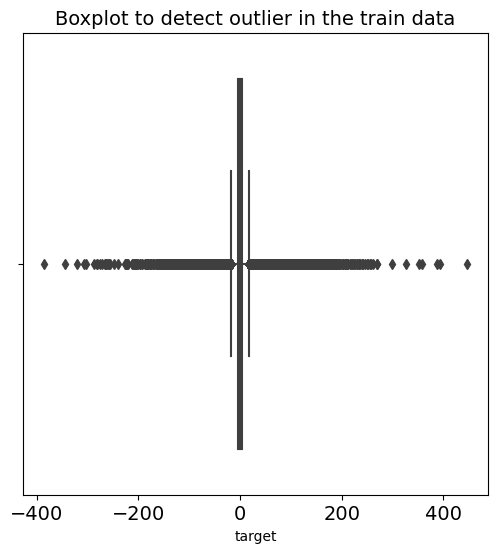

In [16]:
# checking outliers in the data
plt.figure(figsize=(6,6))
plt.title("Boxplot to detect outlier in the train data", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.boxplot(x=imputed_train_df['target'])
plt.show()

In [17]:
#Determine the number of rows containing outliers
# compute the 25th percentile value in target
percentile25 = imputed_train_df['target'].quantile(0.25)

# compute the 75th percentile value in target
percentile75 = imputed_train_df['target'].quantile(0.75)

#compute the interquatile range in target
iqr = percentile75 - percentile25

#define upper limit and lower limit for non-outlier values
upper_limit = percentile75 + (1.5 * iqr)
lower_limit = percentile25 - (1.5 * iqr)
print("Upper Limit:", upper_limit)
print("Lower_Limit:", lower_limit)

#identify the subset pf data containing outliers in target
outliers = imputed_train_df[(imputed_train_df['target'] > upper_limit) | (imputed_train_df['target'] < lower_limit)]

# Count how many rows in the data contain outliers in `target`
print("Number of rows in the data containing outliers in `target`:", len(outliers))


Upper Limit: 17.86351195
Lower_Limit: -18.013715649999998
Number of rows in the data containing outliers in `target`: 292263


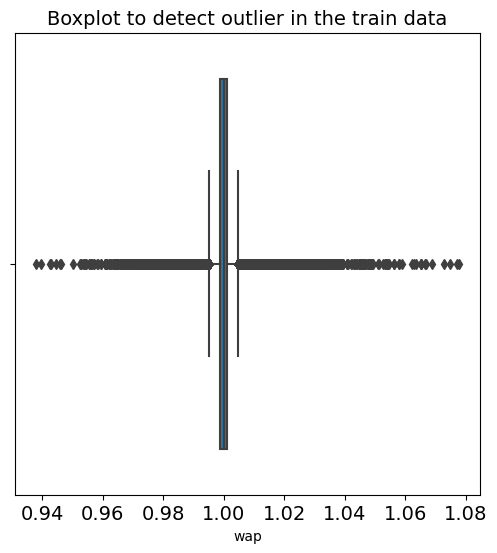

In [18]:
# checking outliers in the train data
plt.figure(figsize=(6,6))
plt.title("Boxplot to detect outlier in the train data", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.boxplot(x=imputed_train_df['wap'])
plt.show()

In [19]:
#Determine the number of rows containing outliers
# compute the 25th percentile value in wap
percentile25 = imputed_train_df['wap'].quantile(0.25)

# compute the 75th percentile value in wap
percentile75 = imputed_train_df['wap'].quantile(0.75)

#compute the interquatile range in wap
iqr = percentile75 - percentile25

#define upper limit and lower limit for non-outlier values
upper_limit = percentile75 + (1.5 * iqr)
lower_limit = percentile25 - (1.5 * iqr)
print("Upper Limit:", upper_limit)
print("Lower_Limit:", lower_limit)

#identify the subset pf data containing outliers in wap
outlier = imputed_train_df[(imputed_train_df['wap'] > upper_limit) | (imputed_train_df['wap'] < lower_limit)]

# Count how many rows in the data contain outliers in `wap`
print("Number of rows in the data containing outliers in `wap`:", len(outliers))


Upper Limit: 1.004701
Lower_Limit: 0.9952289999999999
Number of rows in the data containing outliers in `wap`: 292263


In [20]:
# Log transformation
# data_train['target'] = np.log1p(data_train['target'])


In [21]:
from sklearn.preprocessing import RobustScaler

# Apply robust scaling
scaler = RobustScaler()
data_train['target'] = scaler.fit_transform(data_train['target'].values.reshape(-1, 1))


In [22]:
#Determine the number of rows containing outliers
# compute the 25th percentile value in target
percentile25 = imputed_train_df['target'].quantile(0.25)

# compute the 75th percentile value in target
percentile75 = imputed_train_df['target'].quantile(0.75)

#compute the interquatile range in target
iqr = percentile75 - percentile25

#define upper limit and lower limit for non-outlier values
upper_limit = percentile75 + (1.5 * iqr)
lower_limit = percentile25 - (1.5 * iqr)
print("Upper Limit:", upper_limit)
print("Lower_Limit:", lower_limit)

#identify the subset pf data containing outliers in target
outliers = imputed_train_df[(imputed_train_df['target'] > upper_limit) | (imputed_train_df['target'] < lower_limit)]

# Count how many rows in the data contain outliers in `target`
print("Number of rows in the data containing outliers in `target`:", len(outliers))


Upper Limit: 17.86351195
Lower_Limit: -18.013715649999998
Number of rows in the data containing outliers in `target`: 292263


In [23]:
imputed_train_df.nunique()

stock_id                       200
date_id                        481
seconds_in_bucket               55
imbalance_size             2971863
imbalance_buy_sell_flag          3
reference_price              28741
matched_size               2948862
far_price                    95739
near_price                   84625
bid_price                    28313
bid_size                   2591773
ask_price                    28266
ask_size                   2623254
wap                          31506
target                       15934
time_id                      26455
row_id                     5237980
dtype: int64

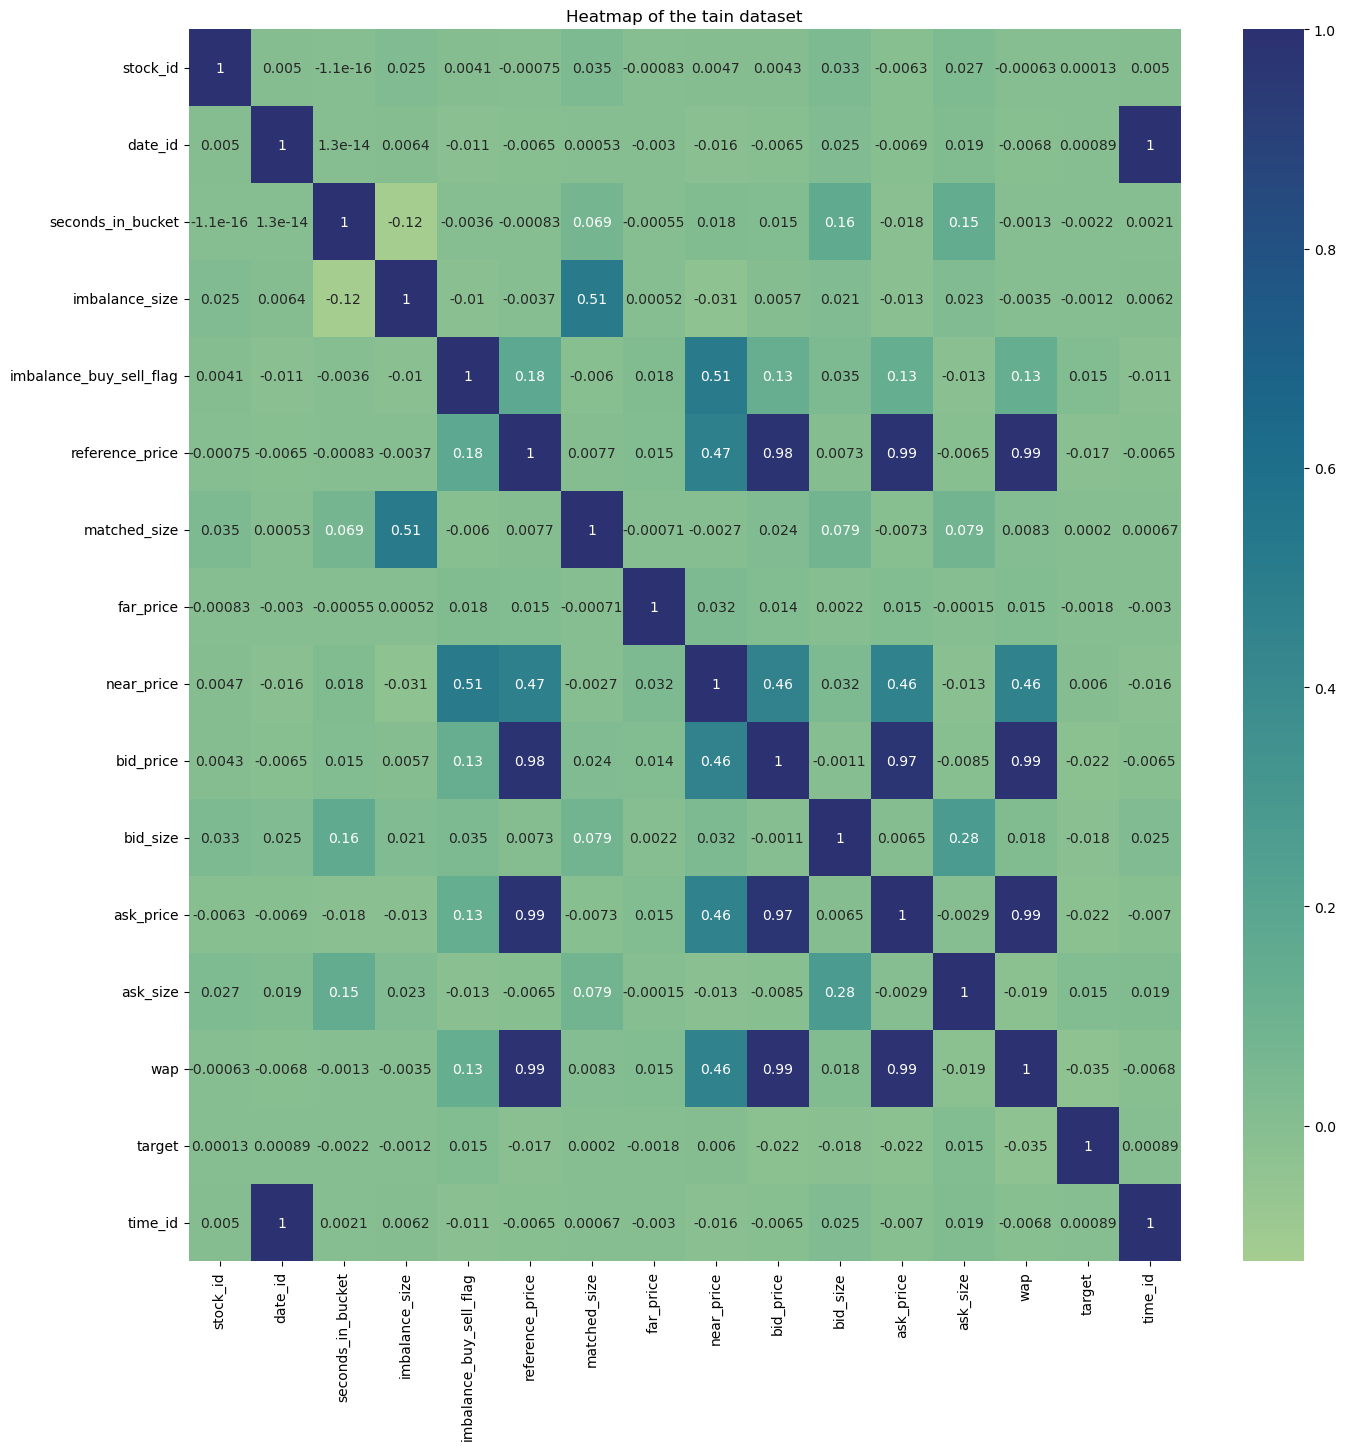

In [24]:
# plotting the heatmap for the train dataset
plt.figure(figsize=(16,16))
sns.heatmap(data_train.corr(),annot=True,cmap='crest')
plt.title('Heatmap of the tain dataset')
plt.show()

In [25]:
print(data_train['imbalance_buy_sell_flag'].value_counts())

-1    2084349
 1    2022037
 0    1131594
Name: imbalance_buy_sell_flag, dtype: int64


In [26]:
data_train['matched_ratio'] = data_train['imbalance_size']/ data_train['matched_size']
data_train.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id,matched_ratio
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-0.331074,0,0_0_0,0.237708
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-0.608719,0,0_0_1,0.101451
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-0.928695,0,0_0_2,0.166475
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-0.440391,0,0_0_3,0.648061
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-0.812733,0,0_0_4,0.025058


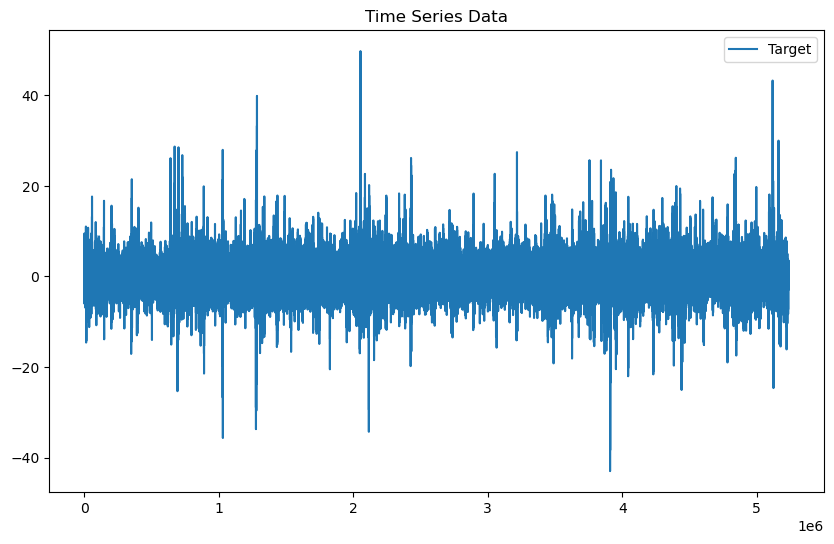

In [27]:
#Visualize the time series data
plt.figure(figsize=(10, 6))
plt.plot(data_train['target'], label='Target')
plt.title('Time Series Data')
plt.legend()
plt.show()

In [28]:
# reseting the index and making a new dataframe with only target data
data_train_target = data_train.reset_index()['target']

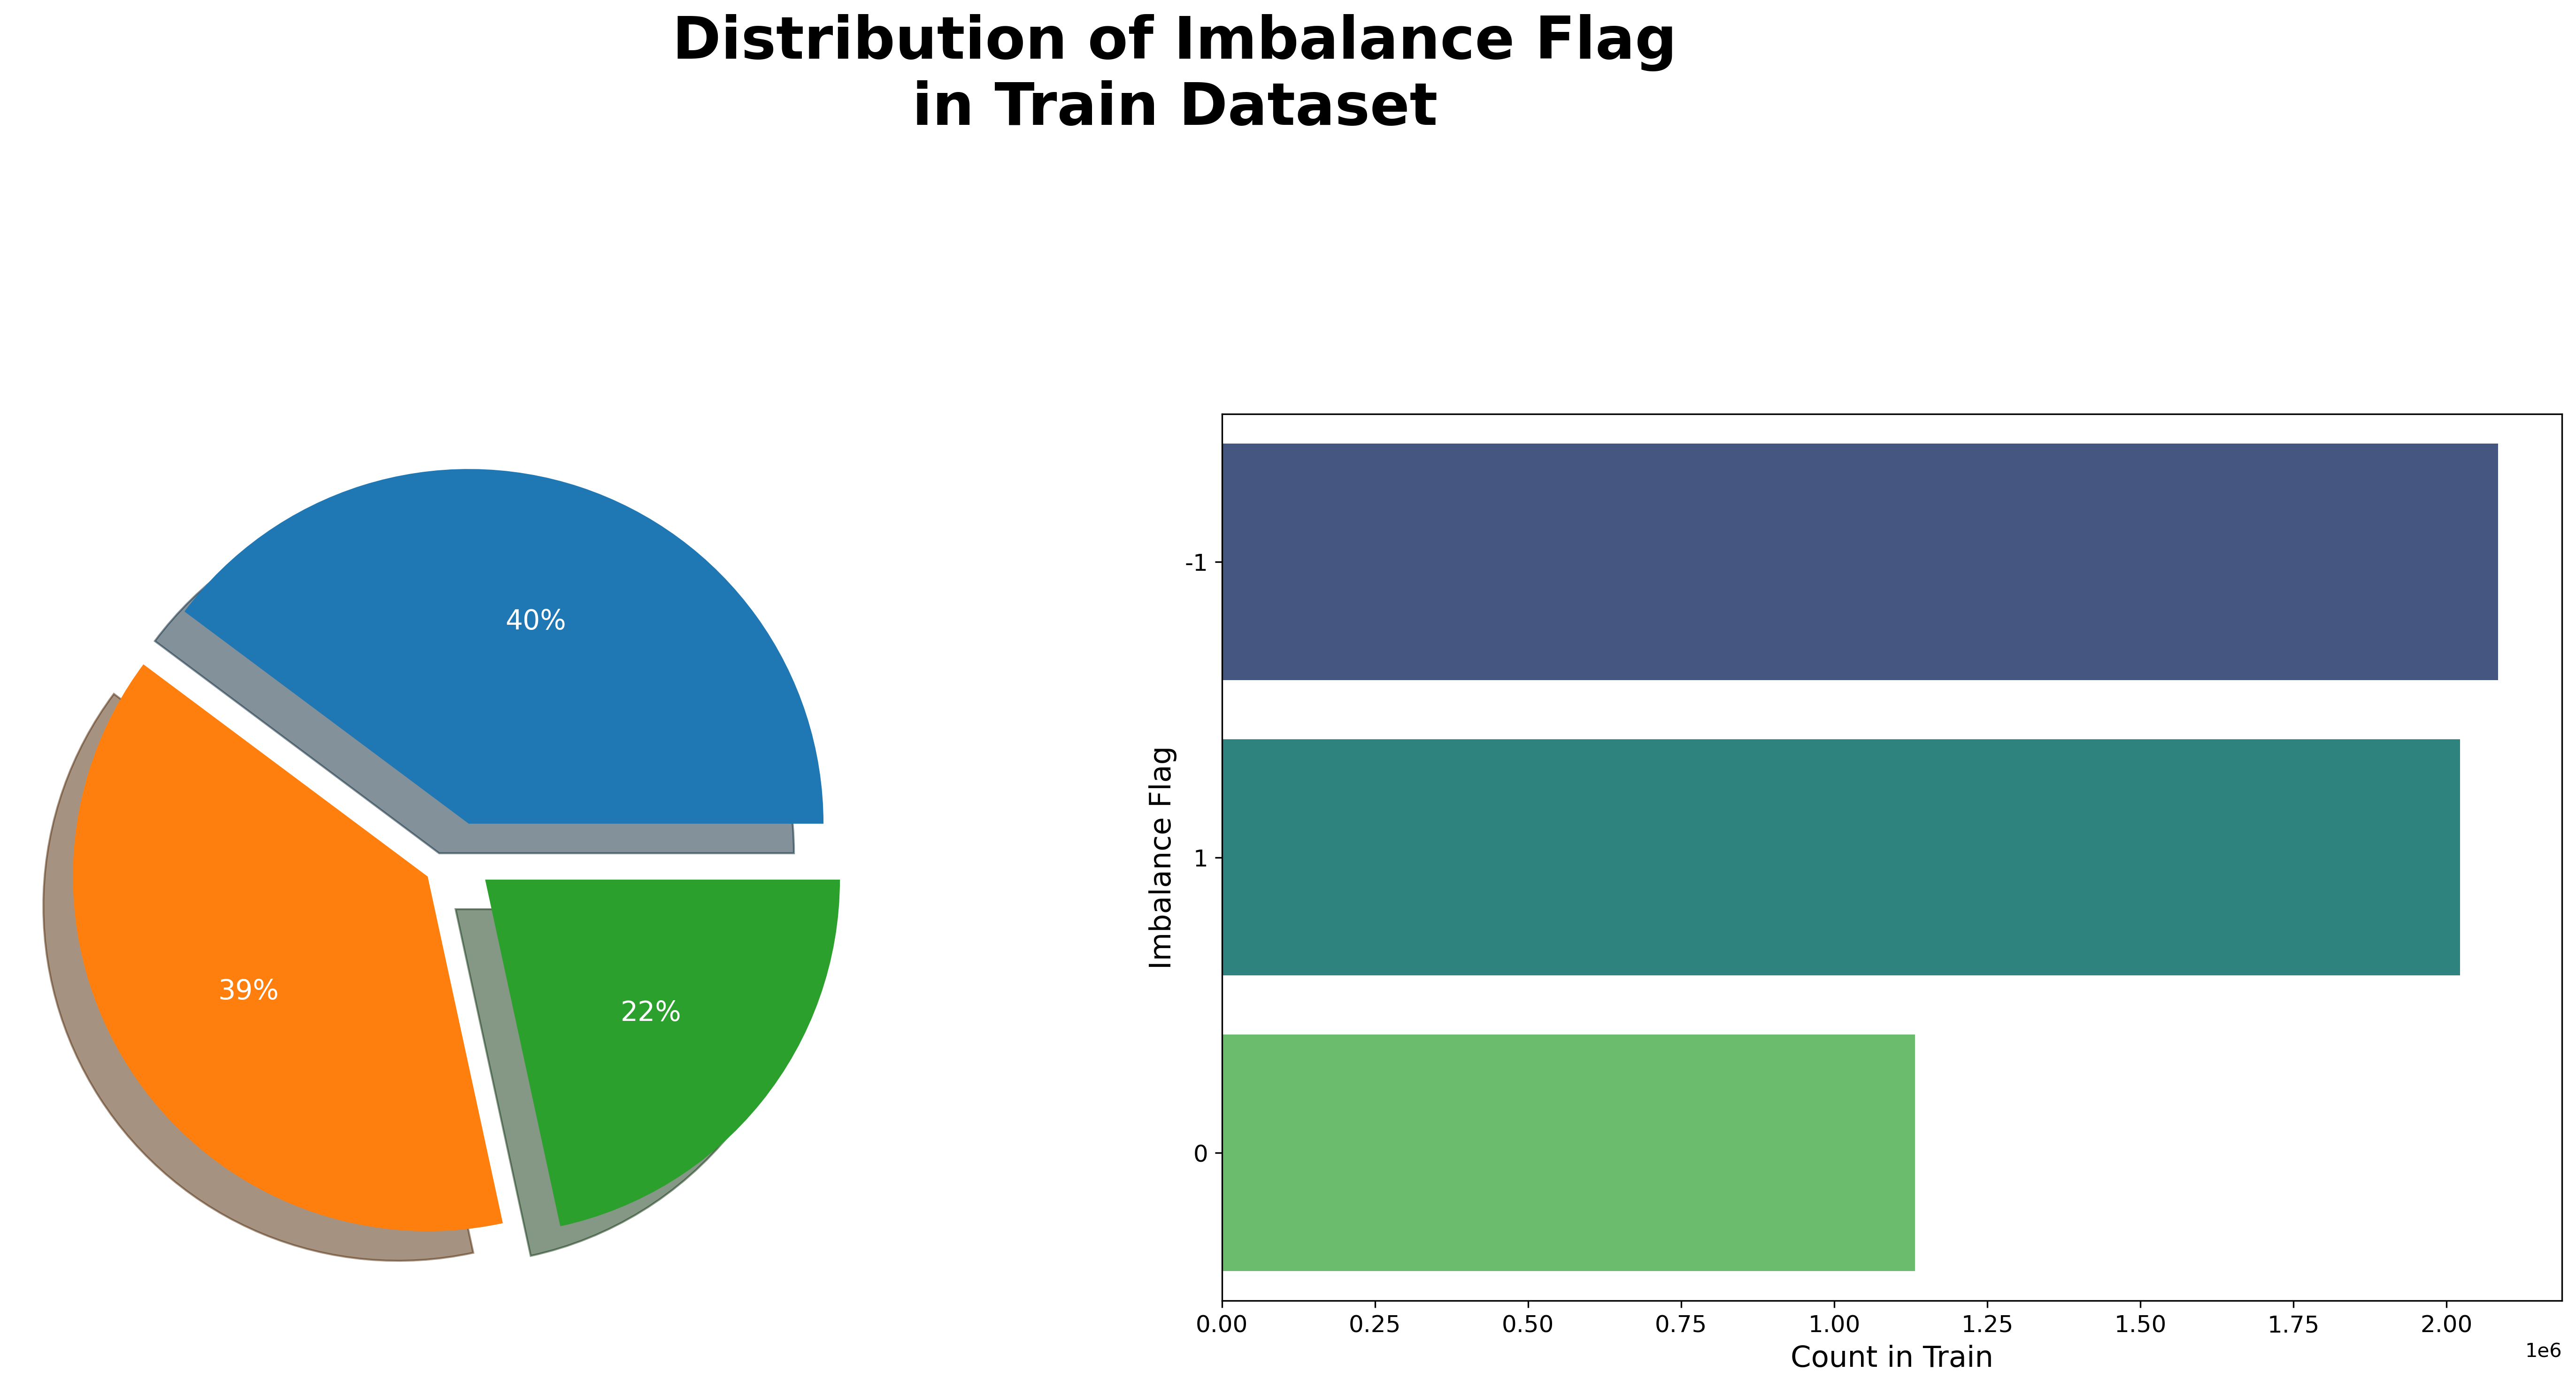

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10), dpi = 300)
ax = ax.flatten()

ax[0].pie(
    imputed_train_df['imbalance_buy_sell_flag'].value_counts(), 
    shadow = True, 
    explode = [.1 for i in range(imputed_train_df['imbalance_buy_sell_flag'].nunique())], 
    autopct = '%1.f%%',
    textprops = {'size' : 14, 'color' : 'white'}
)

sns.countplot(data = imputed_train_df, y = 'imbalance_buy_sell_flag', ax = ax[1], palette = 'viridis', order = imputed_train_df['imbalance_buy_sell_flag'].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax[1].set_xlabel('Count in Train', fontsize = 15)
ax[1].set_ylabel('Imbalance Flag', fontsize = 15)
plt.xticks(fontsize = 12)

fig.suptitle('Distribution of Imbalance Flag\nin Train Dataset\n\n\n\n', fontsize = 30, fontweight = 'bold')
plt.tight_layout()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
count,5237980,5237980,5237980,5237980.0,5237980,5237980.0,5237980.00,5237980.0,5237980.0,5237980.0,5237980.0,5237980.0,5237980.0,5237980.0,5.237980e+06,5237980,5237980
unique,200,481,55,2971863.0,3,28741.0,2948862.00,95739.0,84625.0,28313.0,2591773.0,28266.0,2623254.0,31506.0,1.593400e+04,26455,5237980
top,0,480,0,0.0,-1,1.0,20422.34,1.0,1.0,1.0,0.0,1.0,0.0,1.0,-1.597405e-01,26454,0_0_0
freq,26455,11000,95236,1131663.0,2084349,5942.0,249.00,2895554.0,2858495.0,5724.0,87.0,5715.0,87.0,97158.0,3.565000e+03,200,1


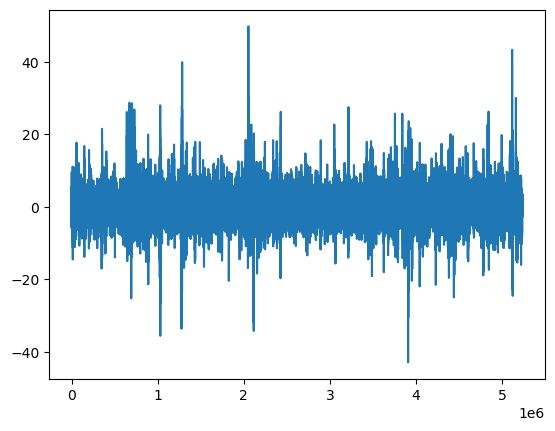

In [29]:
# plotting the train data 2
plt.plot(data_train_target)

In [30]:
# finding the max value
data_train_target.max()

49.739699584814076

In [31]:
# finding the min value
data_train_target.min()

-42.94976229545675

In [32]:
# dataframe for stocks with stock_id = 0
df_stock_id_0 = data_train[data_train['stock_id']==0]

# stock_id = 0 dataframe with only wap column
# df_stock_id_0 = df_stock_id_0.reset_index()['wap']

In [33]:
# plotting the graph

In [34]:
# generating dataframes without row_id, time_id and date_id columns
def feature_cols(dataframe) :
    cols = [c for c in dataframe.columns if c not in ['row_id', 'time_id', 'date_id']]
    dataframe = dataframe[cols]    
    return dataframe

In [35]:
# creating a copy of the training dataset for LightGBM modeling
data_train_lgbm = data_train

# replacing any missing values with 0
data_train_lgbm.fillna(0, inplace = True)

# creating a dataframe with feature columns and dropping the target column
x_train = feature_cols(data_train_lgbm.drop(columns='target'))

# extracting the target column values
y_train = data_train_lgbm['target'].values

In [36]:
# creating a LightGBM regressor model with specified hyperparameters
lgbm_model = lgbm.LGBMRegressor(objective='mae', n_estimators=500, random_state=1234)

# training the model using the preprocessed training data
lgbm_model.fit(x_train, y_train)

LGBMRegressor(n_estimators=500, objective='mae', random_state=1234)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

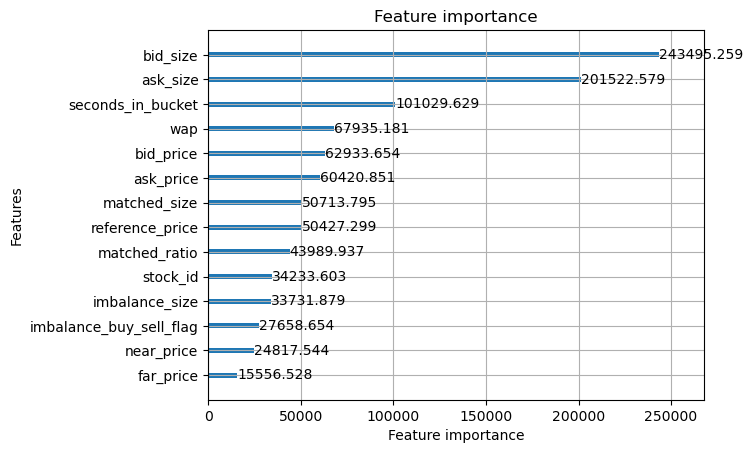

In [37]:
# visualizing feature importance using LightGBM's plot_importance function
lgbm.plot_importance(lgbm_model, importance_type="gain")
